In [1]:
import matplotlib.pyplot as plt
import xarray as xr 
import metpy.calc as mpcalc
from metpy.units import units
from glob import glob
import numpy as np
import pandas as pd
from multiprocessing import Pool
from functools import partial
import os 
from utils import *
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [12]:
file = glob(input_file)
print('Using file '+file[0])
dset = xr.open_dataset(file[0])
#dset = dset.metpy.parse_cf()

Using file /scratch/local1/m300382/icon_forecasts/ICON_2019041006_eur.nc


In [13]:
dset = xr.open_dataset(file[0], decode_times=False)

u'minutes since 2019-4-10 06:00:00'

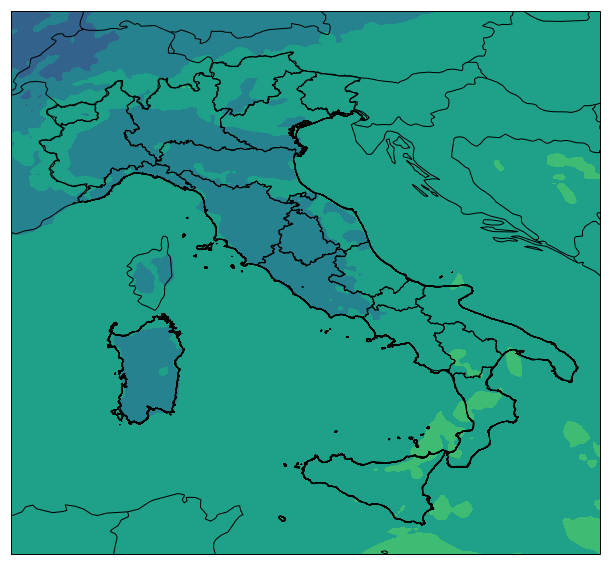

In [42]:
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
adm1_shapes = shpreader.Reader('/home/mpim/m300382/shapefiles/ITA_adm_shp/ITA_adm1.shp').geometries()
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor="black", facecolor="None")

ax.set_extent([6, 19, 36, 48], ccrs.PlateCarree())
ax.contourf(dset.lon, dset.lat, dset.t[0,0,:])

In [3]:
temp_500 = dset['t'].metpy.sel(vertical=500 * units.hPa).metpy.unit_array.to('degC')
gph_500 = mpcalc.geopotential_to_height(dset['z'].metpy.sel(vertical=500 * units.hPa))

lon, lat = get_coordinates(dset)
lon2d, lat2d = np.meshgrid(lon, lat)

time = pd.to_datetime(dset.time.values)
cum_hour=np.array((time-time[0]) / pd.Timedelta('1 hour')).astype("int")

levels_temp = np.arange(-50., 10., 2.5)
levels_gph = np.arange(4800., 5800., 50.)

cmap = get_colormap('temp')

In [136]:
from scipy.ndimage.filters import maximum_filter, minimum_filter
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.ndimage.measurements import center_of_mass, label

In [50]:
gph_500_smooth = gaussian_filter(gph_500[0], sigma=8, order=0)

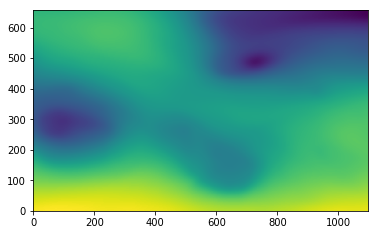

In [51]:
plt.imshow(gph_500_smooth, origin='lower')

In [60]:
data_ext = maximum_filter(gph_500_smooth, 100, mode='nearest')

In [61]:
mxy, mxx = np.where(data_ext == gph_500_smooth)

In [127]:
mxx

array([  69,   70,  309,  696, 1005, 1096, 1056,  241])

In [68]:
np.array(gph_500[0])

array([[5747.5, 5747.5, 5747.5, ..., 5735. , 5735. , 5735. ],
       [5747. , 5747. , 5747. , ..., 5734.5, 5734.5, 5734.5],
       [5746.5, 5746.5, 5746.5, ..., 5733. , 5734. , 5734. ],
       ...,
       [5574. , 5574. , 5574. , ..., 5248.5, 5248.5, 5248. ],
       [5573. , 5573. , 5573. , ..., 5248.5, 5248. , 5248. ],
       [5572. , 5572. , 5572. , ..., 5248. , 5248. , 5247.5]],
      dtype=float32)

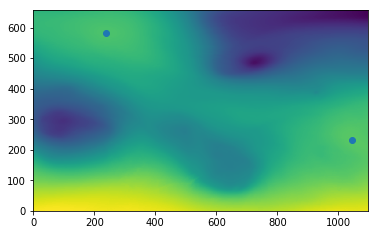

In [156]:
#xy = peak_local_max(np.array(gph_500[0]), min_distance=40)
is_peak = peak_local_max(np.array(gph_500[0]), indices=False, min_distance=50) # outputs bool image
labels = label(is_peak)[0]
merged_peaks = center_of_mass(is_peak, labels, range(1, np.max(labels)+1))
merged_peaks = np.array(merged_peaks)
plt.imshow(gph_500[0], origin='lower')
#plt.plot(xy.T[1], xy.T[0], 'o')
plt.plot(merged_peaks[:,1],merged_peaks[:,0],'o')

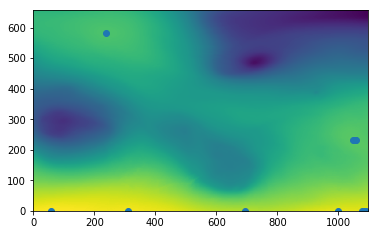

In [168]:
data_ext = maximum_filter(np.array(gph_500[0]), 80, mode='constant')
is_peak = data_ext == np.array(gph_500[0])
labels = label(is_peak)[0]
merged_peaks = center_of_mass(is_peak, labels, range(1, np.max(labels)+1))
merged_peaks = np.array(merged_peaks)
plt.imshow(gph_500[0], origin='lower')
#plt.plot(xy.T[1], xy.T[0], 'o')
plt.plot(merged_peaks[:,1],merged_peaks[:,0],'o')

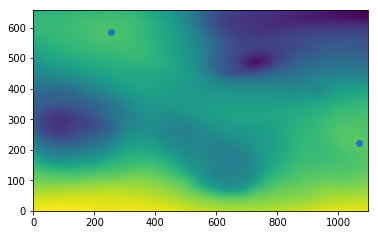

In [208]:
var = np.random.normal(gph_500[0], 1)
data_ext = maximum_filter(var, 80, mode='nearest')
mxy, mxx = np.where(data_ext == var)
plt.imshow(var, origin='lower')
plt.plot(mxx[(mxy != 0) & (mxx != 0)], mxy[(mxy != 0) & (mxx != 0)], 'o')

In [210]:
(mxy != 0) & (mxx != 0)

ValueError: operands could not be broadcast together with shapes (7,) (2,) 